## 🔧 Code guidelines:
- Please follow python coding convention "e.g. imports are alphabetically sorted".
- Use python type hinting for increased readability of your code.
- Please add any helper functions in the helper functions block.
- It is preferred to implement one-time-local-helper-functions inside your parent function.

## 🦦 Managing virtual environments:
```Console
*** Mac:
$ python3 -m venv venv
$ source venv/bin/activate
$ pip3 install -r requirements.txt
$ pip3 freeze > requirements.txt 
$ deactivate

*** Mac:
$ python -m venv venv
$ venv\Scripts\activate.bat
$ pip install -r requirements.txt
$ pip freeze > requirements.txt 
$ deactivate
```

In [94]:
import cv2
import imutils
import matplotlib.pyplot as plt
import numpy as np
import skimage as sk
import skimage.measure
from skimage.morphology import binary_erosion
from typing import Final


In [95]:
# [0]: Add helper functions here
def show_images(images, titles=None):
    """Display a list of images in a single figure with matplotlib."""
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images,titles), start=1):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2: 
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        plt.axis('off')
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()

In [96]:
# [1]: Crop Number Plate
def crop_image(image: np.ndarray) -> np.ndarray:
    # [0]: Local CONSTANTS
    CANNY_THRESH_LOW: Final[int] = 170
    CANNY_THRESH_HIGH: Final[int] = 200
    BILATERAL_FILTER_SIZE: Final[int] = 11
    BILATERAL_FILTER_SIGMA_COLOR: Final[int] = 17
    BILATERAL_FILTER_SIGMA_SPACE: Final[int] = 17
    MAX_NUM_CONTOURS: Final[int] = 30
    # [1]: Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # [2]: Reduce noise and preserve edges
    gray = cv2.bilateralFilter(
        gray, 
        BILATERAL_FILTER_SIZE, 
        BILATERAL_FILTER_SIGMA_COLOR, 
        BILATERAL_FILTER_SIGMA_SPACE
    )
    # [3]: Edge Detection
    edges = cv2.Canny(gray, CANNY_THRESH_LOW, CANNY_THRESH_HIGH)
    # [4]: Find contours && sort by their area
    contours, _ = cv2.findContours(edges.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:MAX_NUM_CONTOURS]
    # [5]: Find contour with 4 corners
    def get_image(contour) -> np.ndarray:
        x, y, w, h = cv2.boundingRect(contour)
        return gray[y:y+h, x:x+w]
    return [
        get_image(c)
        for c in contours 
        if cv2.approxPolyDP(c, 0.01 * cv2.arcLength(c, True), True).shape[0] == 4
    ][0]

In [97]:
# [2]: Skew Rotation Correction
def rotate_image(image: np.ndarray) -> np.ndarray:
    # [0]: Local CONSTANTS
    CANNY_THRESH_LOW: Final[int] = 0
    CANNY_THRESH_HIGH: Final[int] = 100
    # [2]: Edge Detection
    edges = cv2.Canny(image, CANNY_THRESH_LOW, CANNY_THRESH_HIGH)
    # [3]: Hough Transform
    lines = cv2.HoughLines(edges, 1, np.pi/180, 40)
    # [4]: Find most common angle
    angle = np.degrees(max(
        (line[0][1] for line in lines), 
        key=lambda x: list(lines[:,0,1]).count(x)
    ))
    # [5]: Rotate the image
    return sk.transform.rotate(
        image,
        angle+90 if angle<0 else angle-90
    )

In [98]:
# [3]: Character Segmentation
def segment_Character(image: np.ndarray) -> np.ndarray:
    image_out = np.zeros(image.shape)
    # [1]: Threshold Image using OTSU for automatic thresholding
    Threshold = sk.filters.threshold_otsu(image)
    image_out[image <= Threshold] = 1
    # show_images([ image_out])

    # [2]: Detect Contours around each character
    contours = sk.measure.find_contours(image_out, 0.8)
    bounding_boxes = []
    for contour in contours:
        startY, endY = min(contour[:, 0]), max(contour[:, 0])
        startX, endX = min(contour[:, 1]), max(contour[:, 1])
        ratio = (endY-startY)/(endX-startX)
        if(1 < ratio < 3):
            tup = map(int, np.round((startX, endX, startY, endY)))
            endY-startY > 5 and endX - \
                startX > 5 and bounding_boxes.append(tuple(tup))

    # [3]: Sort the boundring boxes to make sure that the characters are drawin in the right order
    bounding_boxes = sorted(bounding_boxes, key=lambda x: x[0])

    # [4] : Draw a Box surrounding the character
    img_with_boxes = np.copy(image)  # np.zeros(image.shape)
    # When provided with the correct format of the list of bounding_boxes, this section will set all pixels inside boxes in img_with_boxes
    for box in bounding_boxes:
        [Xmin, Xmax, Ymin, Ymax] = box
        rr, cc = sk.draw.rectangle_perimeter(
            start=(Ymin, Xmin), end=(Ymax, Xmax), shape=image.shape)
        img_with_boxes[rr, cc] = 1  # set color white
    Xmin, Xmax, Ymin, Ymax = bounding_boxes[1]
    # print(image[Ymin:Ymax,Xmin,Xmax])

    # [5]: create a list of images cropped images for each character
    character_Image_list = []
    CHARACTER_PADDING_X: Final[int] = 2
    CHARACTER_PADDING_Y: Final[int] = 2
    for box in bounding_boxes:
        character = image_out[box[2]-CHARACTER_PADDING_Y:box[3] +
                              CHARACTER_PADDING_Y, box[0]-CHARACTER_PADDING_X:box[1]+CHARACTER_PADDING_X]
        character_Image_list.append(character)

    # show_images(character_Image_list)
    # for i in range(len(character_Image_list)):
    #     plt.subplot(1, len(character_Image_list), i+1)
    #     plt.imshow(character_Image_list[i], cmap='gray')
    #     plt.axis('off')
    # plt.show()

    # ---> List of boxes for each character
    return character_Image_list


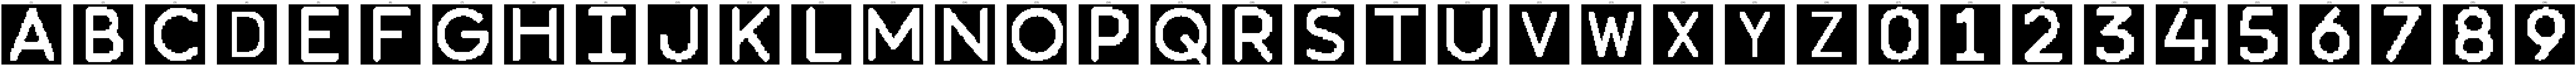

In [130]:
# Get Characters
import os

Characters = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z", "0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

CharTemplate = []

# read all files in template folder and store them in CharTemplate
for index, char in enumerate(Characters):
    CharTemplate.append((sk.io.imread('templates/'+char+'.jpg') > 200).astype(np.uint8)*255)
show_images(CharTemplate)


In [131]:
# [4]: Character reconigtion

def calculateTheEuclideanDistance(image1, image2):
    # sum of absolute differences between the pixels of the two images
    return np.linalg.norm(image1.flatten()-image2.flatten())

def calculateTheCrossCorrelation(image1, image2):
    # Calculate the cross correlation between two images
    # The cross correlation is the sum of the product of the pixels of the two images
    return np.sum(image1*image2)

def calculateTheNormalizedCrossCorrelation(image1, image2):
    # Calculate the normalized cross correlation between two images
    # The normalized cross correlation is the sum of the product of the pixels of the two images divided by the product of the standard deviations of the two images
    return np.sum(image1*image2)/(np.std(image1)*np.std(image2))

def getMaxIndex(list):
    max = 0
    index = 0
    for i in range(len(list)):
        if list[i] > max:
            max = list[i]
            index = i
    return index

def characterRecognition (license):
    text = ''
    
    for charac in license:
        # resize image
        charac= charac.astype(np.int8)*255
        charac = sk.transform.resize(charac, (48, 48))
        charac = (charac*255).astype(np.int8)

        templateMatchingValues = []

        for i in range (len(CharTemplate)):
            crossCorrelation = calculateTheCrossCorrelation(charac, CharTemplate[i])
            euclideanDistance = calculateTheEuclideanDistance(CharTemplate[i],charac)
            normalizedCrossCorrelation = calculateTheNormalizedCrossCorrelation(CharTemplate[i],charac)
            templateMatchingValues.append(crossCorrelation/(euclideanDistance + normalizedCrossCorrelation) )
        text += Characters[getMaxIndex(templateMatchingValues)]

    return text
    

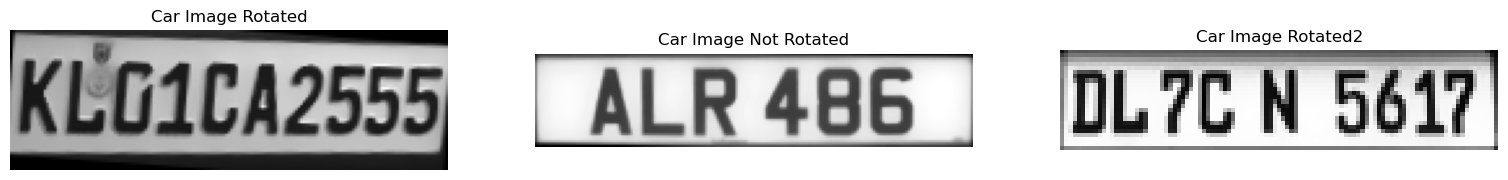

KLWO2CA2555
AER4GG
0L98N8629


In [129]:
car1_image = cv2.imread('./samples/rotation.png')
car2_image = cv2.imread('./samples/no-rotation.png')
car3_image = cv2.imread('./samples/no-rotation1.png')
cars=[car1_image,car2_image,car3_image]
#show_images(cars, ["Input Image1","Input Image2","Input Image"])

cars_image_cropped = [crop_image(car) for car in cars]
#show_images(cars_image_cropped, ["Car Image Cropped","Car Image Cropped","Car Image Cropped"])

car_image_rotated = [rotate_image(car) for car in cars_image_cropped]
show_images(car_image_rotated, ["Car Image Rotated","Car Image Not Rotated","Car Image Rotated2"])

chars = [segment_Character(car) for car in car_image_rotated]
#for i in range(len(chars)): show_images(chars[i])


for i in range(len(chars)): print(characterRecognition(chars[i]))
